In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sentence_transformers import SentenceTransformer

# Set the visual style for the charts
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Arial'] # Support for Thai fonts if installed

/Users/patiparnnualchan/Documents/2026_AI_Project/sentence_similarity-semantic/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
print("📦 Loading data...")
# Go up one folder level to find the data directory
df = pd.read_csv("../data/mock_customer_data.csv")

print("🧠 Generating Embeddings with E5...")
model = SentenceTransformer('intfloat/multilingual-e5-base')
# E5 requires the "query: " prefix for clustering
sentences = ["query: " + str(s) for s in df['customer_text']]
embeddings = model.encode(sentences, show_progress_bar=True)

📦 Loading data...
🧠 Generating Embeddings with E5...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1450.47it/s, Materializing param=pooler.dense.weight]                               
XLMRobertaModel LOAD REPORT from: intfloat/multilingual-e5-base
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


In [11]:
print("📉 Compressing to 2D for visualization...")
reducer_2d = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42)
embeddings_2d = reducer_2d.fit_transform(embeddings)

# Add the X and Y coordinates to our dataframe
df['x_coord'] = embeddings_2d[:, 0]
df['y_coord'] = embeddings_2d[:, 1]

📉 Compressing to 2D for visualization...


/Users/patiparnnualchan/Documents/2026_AI_Project/sentence_similarity-semantic/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


⚡ Grouping dots using our saved HDBSCAN & UMAP models...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1439.16it/s, Materializing param=pooler.dense.weight]                               
XLMRobertaModel LOAD REPORT from: intfloat/multilingual-e5-base
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


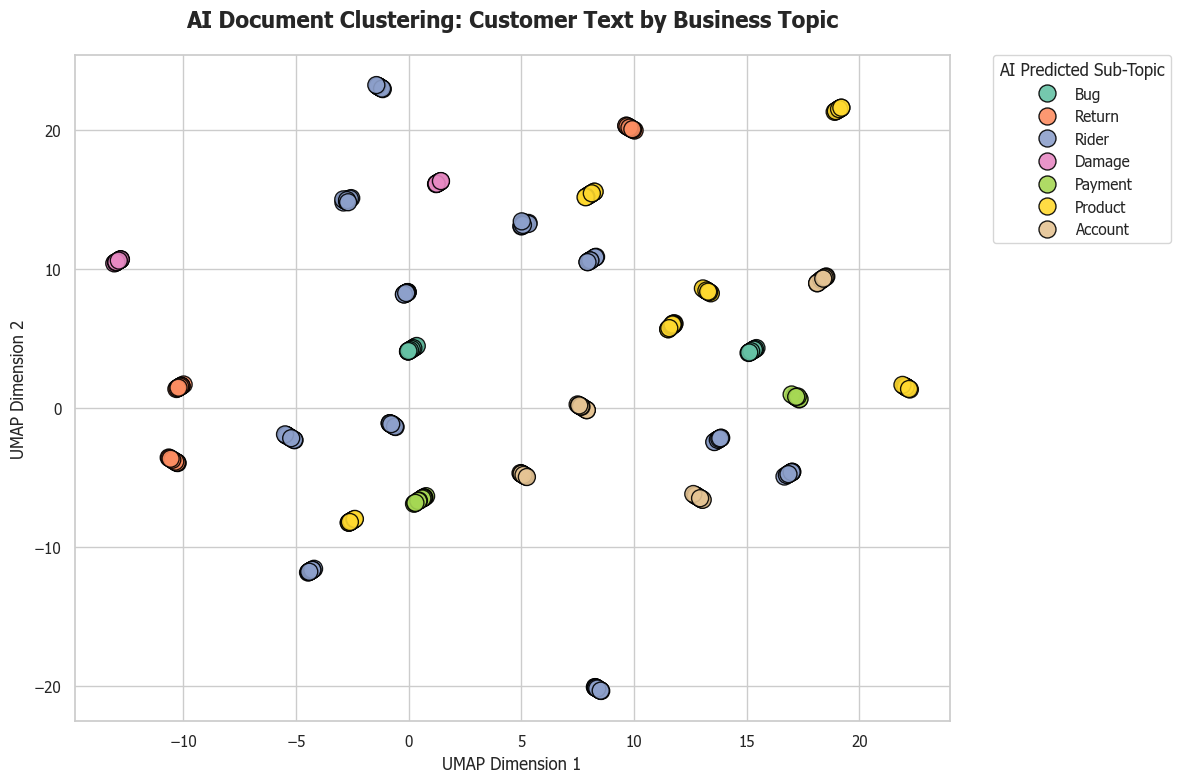

In [12]:
import sys
import os
# Tell Python to look in the parent folder (the main project folder)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# NOW import your actual pipeline engine!
from src.clusterer import predict_clustering_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

print("⚡ Grouping dots using our saved HDBSCAN & UMAP models...")
# Run the fast local inference to get the real sub_topic labels
df_viz = predict_clustering_pipeline(df, text_col="customer_text")

plt.figure(figsize=(12, 8))

# Create the scatter plot
scatter = sns.scatterplot(
    data=df_viz, 
    x='x_coord', 
    y='y_coord', 
    hue='sub_topic',    # 🎯 THE MAGIC CHANGE: Color by the AI's predicted topic!
    palette='Set2',     # A professional color palette
    s=150, 
    alpha=0.9,
    edgecolor='black'
)

# Add title and labels
plt.title("AI Document Clustering: Customer Text by Business Topic", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="AI Predicted Sub-Topic")
plt.tight_layout()

plt.show()

In [8]:
import pandas as pd
import random
import string

print("🔄 Expanding 30 rows into 450 rows for visualization...")

# 1. Load the original 30 rows
df_original = pd.read_csv("../data/mock_customer_data.csv")

expanded_data = []
ticket_counter = 1

# 2. Duplicate the data 15 times
for _ in range(15):
    for index, row in df_original.iterrows():
        # Add a random reference code to create a slight math shift!
        random_ref = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
        new_text = f"{row['customer_text']} [Ref: {random_ref}]"
        
        expanded_data.append({
            "topic_key": f"TKT-{str(ticket_counter).zfill(4)}",
            "customer_text": new_text
        })
        ticket_counter += 1

# 3. Overwrite the CSV with the new massive dataset
df_massive = pd.DataFrame(expanded_data)
df_massive.to_csv("../data/mock_customer_data.csv", index=False)

print(f"✅ Success! Your mock_customer_data.csv now has {len(df_massive)} rows.")

🔄 Expanding 30 rows into 450 rows for visualization...
✅ Success! Your mock_customer_data.csv now has 450 rows.


In [9]:
df_massive

,topic_key,customer_text
0,TKT-0001,สั่งของไปสามวันแล้วยังไม่ได้เลยครับ ช้ามาก [Re...
1,TKT-0002,ขนส่งสาขานี้ดองของไว้หลายวัน ไม่ยอมมาส่ง [Ref:...
2,TKT-0003,สถานะขึ้นว่าจัดส่งสำเร็จ แต่ยังไม่ได้รับของเลย...
3,TKT-0004,กล่องพัสดุบุบยับเยินมาก ดีที่ของข้างในไม่พัง [...
4,TKT-0005,พนักงานขนส่งพูดจาไม่สุภาพเลย แย่มาก [Ref: DNQYO]
...,...,...
445,TKT-0446,สนใจสมัครเปิดร้านค้าในแอปต้องทำยังไงครับ [Ref:...
446,TKT-0447,โปร 11.11 เริ่มกี่โมงครับ มีของแจกไหม [Ref: MC...
447,TKT-0448,สมาชิก VIP ได้รับส่วนลดเพิ่มกี่เปอร์เซ็นต์ [Re...
448,TKT-0449,ดีมากกกก ใช้งานง่าย ชอบๆ 👍 [Ref: 8DC87]
